# FIGURE 2

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from msresist.parameter_tuning import kmeansPLSR_tuning
from msresist.plsr import MeasuredVsPredicted_LOOCVplot, Q2Y_across_components, R2Y_across_components
from msresist.clustering import MyOwnKMEANS, ClusterAverages
from msresist.sequence_analysis import FormatName, pYmotifs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing, Log2T, MeanCenter, MergeDfbyMean, LinearScale, FoldChangeFilter, VFilter, FoldChangeToControl
from FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

### Importing and Pre-processing Data

### Phosphorylation measurements:

In [2]:
A_r = pd.read_csv('./msresist/data/Raw/20180817_JG_AM_TMT10plex_R1_psms_raw.csv', header=0)
B_r = pd.read_csv('./msresist/data/Raw/20190214_JG_AM_PC9_AXL_TMT10_AC28_R2_PSMs_raw.csv', header=0)
C_r = pd.read_csv('./msresist/data/Raw/CombinedBR3_TR1&2_raw.csv', header=0)

header = A_r.columns
treatments = A_r.columns[2:]

ABC_mc = preprocessing(A_r, B_r, C_r, motifs=True, Vfilter=True, FCfilter=True, log2T=True)

data = ABC_mc.iloc[:,2:].T
protnames = list(ABC_mc.iloc[:,1])
seqs = list(ABC_mc.iloc[:,0])

In [3]:
ABC_mc.shape

(415, 12)

### Phenotypes

#### Cell Viability:

% Confluency:

In [4]:
Y_cv = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]

Optionally take the fold-change to t=0:

In [5]:
# Y_cv.iloc[:, 1:] = Y_cv.iloc[:, 1:].div(Y_cv.iloc[0, 1:], axis = 1)

Define time-point of interest:

In [6]:
Y_cv = Y_cv[Y_cv["Elapsed"] == 87].iloc[0, 1:11]

## 1. Cross-validation

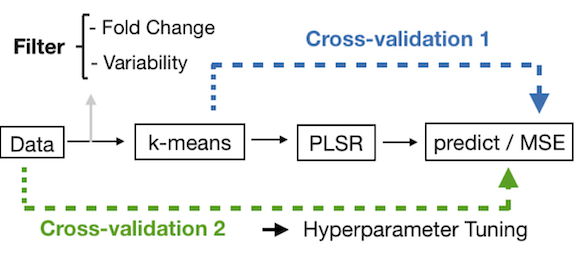

In [7]:
from IPython.display import Image
Image(filename='Model_pipeline.jpg')

### 1.1 Strategy 1: R2Y/Q2Y after k-means clustering (k=5)

Cross-validation fitting averages of k-means clusters into the PLSR model. Number of clusters must be set in advance:

In [41]:
ncl = 4

In [42]:
kmeans = MyOwnKMEANS(ncl).fit(data, Y_cv)
centers = kmeans.transform(data)

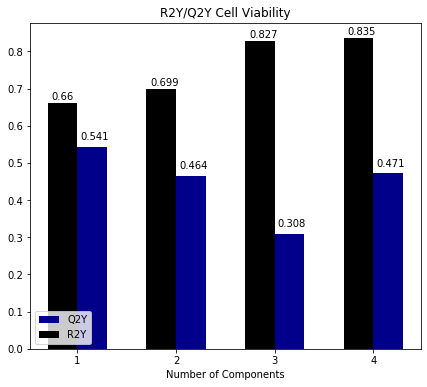

In [43]:
maxComp = ncl
Q2Y = Q2Y_across_components(centers, Y_cv, maxComp+1)
R2Y = R2Y_across_components(centers, Y_cv, maxComp+1)
def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

def disp_values(x,spac1,spac2,dec):
    for l, m in enumerate(x):
        plt.text(l+spac1,m+spac2,str(truncate(m,dec)))    #change to axs[ax].

range_ = np.linspace(1,maxComp,maxComp)

fig, axs = plt.subplots(1,1,figsize=(7,6))
plt.setp(axs, xticks=range_)
plt.bar(range_+0.15,Q2Y,width=0.3,align='center',label='Q2Y', color = "darkblue")
plt.bar(range_-0.15,R2Y,width=0.3,align='center',label='R2Y', color = "black")
plt.title("R2Y/Q2Y Cell Viability")
plt.xlabel("Number of Components")
plt.legend(loc=3)
disp_values(Q2Y,1.03,0.02,3)
disp_values(R2Y,0.74,0.01,3)

### 1.2 Strategy 2: Gridsearch

Cross-validation fitting averages of k-means clusters into the PLSR model. Simulatenous tuning of number of clusters and number of components using GridSearch:

In [12]:
CVresults_max, CVresults_min, best_params = kmeansPLSR_tuning(data, Y_cv)
CVresults_min.nlargest(20, "mean_test_scores")

,#Clusters,#Components,mean_test_scores,mean_train_scores
2,3,1,-277.610749,-199.719904
9,5,1,-289.667463,-202.651948
5,4,1,-294.689761,-210.208400
14,6,1,-297.811206,-199.085441
54,11,1,-302.807417,-200.053526
104,15,1,-307.324885,-191.663596
77,13,1,-308.377753,-197.172398
10,5,2,-309.025365,-184.450843
35,9,1,-311.007601,-206.557143
1,2,2,-314.254043,-208.374125


## 2. Model Predicted vs Actual for best Hyperparameter Set

In [44]:
ncl, ncomp = 4, 4

### 2.1 With CV Strategy 1:

Pearson's R:  0.6962850551215998 
 p-value:  0.02530089686033633


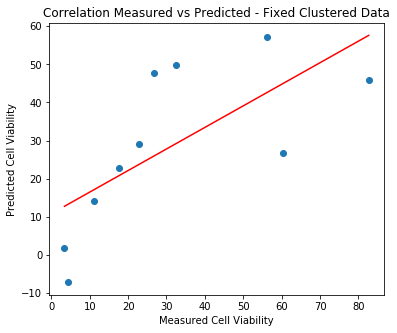

In [45]:
fig, axs = plt.subplots(1,1,figsize=(6,5))
MeasuredVsPredicted_LOOCVplot(centers, Y_cv, PLSRegression(ncomp), fig, "none", axs)
plt.title("Correlation Measured vs Predicted - Fixed Clustered Data")
plt.xlabel("Measured Cell Viability")
plt.ylabel("Predicted Cell Viability");

### 2.2 With CV Strategy 2:

In [46]:
estimators = [('kmeans', MyOwnKMEANS(ncl)), ('plsr', PLSRegression(ncomp))]
kmeans_plsr = Pipeline(estimators)

In [47]:
X_scores, Y_scores = kmeans_plsr.fit_transform(data, Y_cv)
PC1_scores, PC2_scores = X_scores[:, 0], X_scores[:, 1]
PC1_xload, PC2_xload = kmeans_plsr.named_steps.plsr.x_loadings_[:, 0], kmeans_plsr.named_steps.plsr.x_loadings_[:, 1]
PC1_yload, PC2_yload = kmeans_plsr.named_steps.plsr.y_loadings_[:, 0], kmeans_plsr.named_steps.plsr.y_loadings_[:, 1]

Pearson's R:  0.7155697203817406 
 p-value:  0.019971908601877576


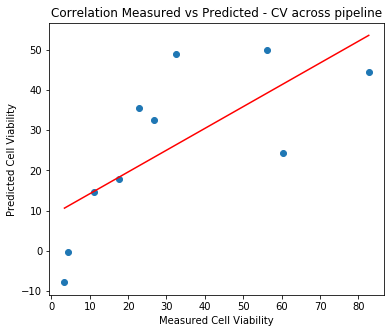

In [48]:
fig, axs = plt.subplots(1,1,figsize=(6,5))
MeasuredVsPredicted_LOOCVplot(data, Y_cv, kmeans_plsr, fig, "none", axs)
plt.title("Correlation Measured vs Predicted - CV across pipeline")
plt.xlabel("Measured Cell Viability")
plt.ylabel("Predicted Cell Viability");

## 3. PLSR scores and loadings 

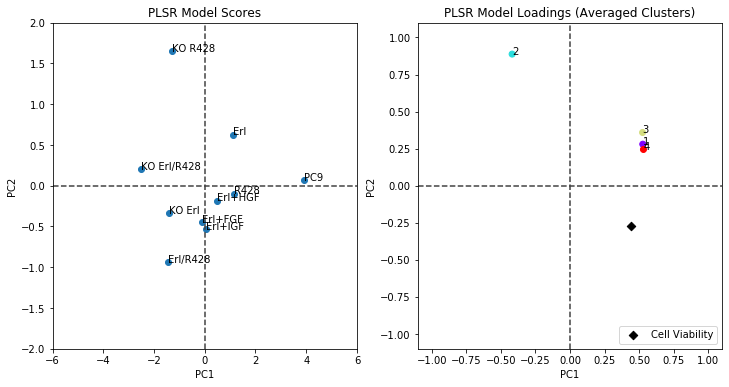

In [49]:
fig, axs = plt.subplots(1, 2,figsize=(12,6))

colors_ = cm.rainbow(np.linspace(0, 1, ncl))


axs[0].scatter(PC1_scores,PC2_scores)
for j, txt in enumerate(treatments):
    axs[0].annotate(txt, (PC1_scores[j], PC2_scores[j]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].axhline(y=0, color='0.25', linestyle='--')
axs[0].axvline(x=0, color='0.25', linestyle='--')
axs[0].set_xlim([-6, 6])
axs[0].set_ylim([-2, 2])

numbered=[]
list(map(lambda v: numbered.append(str(v+1)), range(ncl)))

for i, txt in enumerate(numbered):
    axs[1].annotate(txt, (PC1_xload[i], PC2_xload[i]))
axs[1].scatter(PC1_xload, PC2_xload, c=np.arange(ncl), cmap=colors.ListedColormap(colors_))
axs[1].scatter(PC1_yload, PC2_yload, color='#000000', marker='D', label='Cell Viability')
axs[1].legend(loc=4)
axs[1].set_title('PLSR Model Loadings (Averaged Clusters)')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
axs[1].set_xlim([-1.1, 1.1])
axs[1].set_ylim([-1.1, 1.1]);

In [50]:
clustermembers = kmeans_plsr.named_steps.kmeans.clustermembers(ABC_mc.T)
clustermembers

,Cluster_1,seqs_Cluster_1,Cluster_2,seqs_Cluster_2,Cluster_3,seqs_Cluster_3,Cluster_4,seqs_Cluster_4
0,Matrin-3,TREPPyRVPRD,Mitogen-activated protein kinase 10,FMMtPyVVTRY,"1-phosphatidylinositol 4,5-bisphosphate phosph...",RNPGFyVEANP,Neuroblast differentiation-associated protein ...,KVKGEyDMTVP
1,Mitogen-activated protein kinase 13,ADAEMtGYVVT,Mitogen-activated protein kinase 11,TGYVAtRWYRA,MICAL-like protein 1,QADVEyELRCL,Neuroblast differentiation-associated protein ...,NVKGEyDVTMP
2,Lysosomal-associated transmembrane protein 4B,EPPPPyVSA,Mitogen-activated protein kinase 8,FMMtPyVVTRY,Kin of IRRE-like protein 1,SHSSGyAQLNT,Plakophilin-3,TSRGQyHTLQA
3,Mitotic interactor and substrate of PLK1,YTGQPsPRGLH,Mitogen-activated protein kinase 8,FMMTPyVVTRY,Kinesin-like protein KIF20A,LKRSVyIESRI,PDZ and LIM domain protein 1,TPPEGyEVVTV
4,Myosin light polypeptide 6,GTYEDyVEGLR,La-related protein 1,LIVTQtPHYMR,LIM and SH3 domain protein 1,ISNIKyHEEFE,PDZ and LIM domain protein 4,LGSEVyRMLRE
5,Myosin-9,LDSNLyRIGQS,Kin of IRRE-like protein 1,DPTNGyYNVRA,Lethal(2) giant larvae protein homolog 1,CFDPYsDDPRL,Palladin,PSASRyAALSD
6,Lipoma-preferred partner,NDSDPtYGQQG,Plakophilin-2,GNLHRtSSVPE,Lethal(2) giant larvae protein homolog 1,GCFDPySDDPR,Hepatocyte growth factor receptor,KCVAPyPSLLS
7,Kin of IRRE-like protein 1,SQHSDyGQRFQ,Niban-like protein 1,MDNAVyTFETL,Lipolysis-stimulated lipoprotein receptor,GGQGSyVPLLR,Filamin-B,ESVTRsSTETC
8,Kinesin light chain 2,AEEVEyYYRRA,Osteoclast-stimulating factor 1,TDAVRtLSNAE,Perilipin-3,ASASEyAHRGL,Integrin beta-4,TLTRDyNSLTR
9,Lethal(2) giant larvae protein homolog 2,SFDPYsDDPRL,G-patch domain and KOW motifs-containing protein,MGPSDtDDD,Peroxiredoxin-1,tIAQDyGVLKA,Thyroid receptor-interacting protein 6,PDRQAyEPPPP


#### Cluster Averages across Conditions

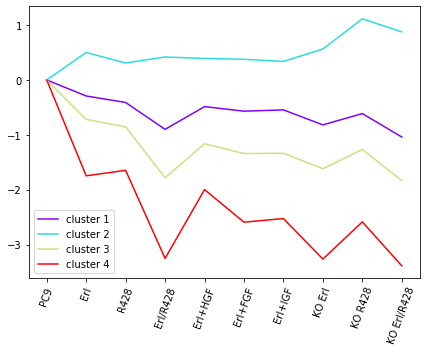

In [51]:
fig = plt.figure(figsize=(7,5))

centers = kmeans_plsr.named_steps.kmeans.transform(data).T

for i in range(centers.shape[0]):
    plt.plot(centers.iloc[i,:], label = "cluster "+str(i+1), color = colors_[i])
    
plt.legend()
plt.xticks(np.arange(centers.shape[1]), (treatments), rotation=70);